# (top)

In [ ]:
import os

os.chdir(os.path.expanduser("~/l3_project"))
# for when on NCC to be able to import local packages

In [1]:
import time
import platform

import numpy as np
import einops.einops as einops
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
import torchvision.transforms as transforms
import wandb
import safetensors.torch as st

import datasets.core
import datasets.eurosat

print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

C:\Users\lucah\miniconda3\envs\cs_project_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using PyTorch 2.5.0 on Windows
Found NVIDIA GeForce RTX 3070 to use as a cuda device.
Using cuda as torch device.
Set number of threads to 1 as using a non-Linux machine.


In [2]:
# sanity check for imports
datasets.core.get_dataset_root()

WindowsPath('H:/hdd_datasets')

# EuroSAT Dataset

There are 16200 training samples
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=False)
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[0.0, 0.0], shear=[-0.2, 0.2])
    RandomAffine(degrees=[0.0, 0.0], scale=(1.0, 1.2))
    datasets.core.ClampTransform(min=0.0, max=2750.0)
)


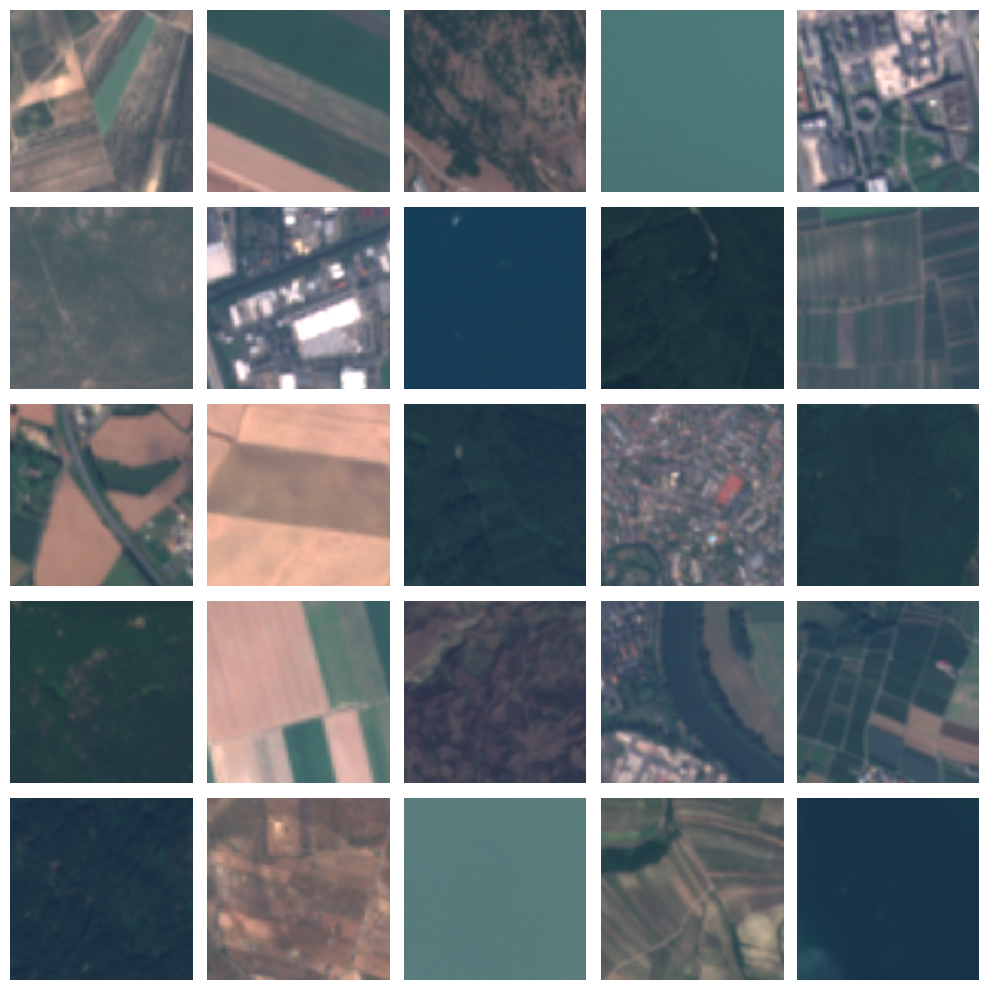

In [3]:
base_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=False),  # Authors rescale images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, shear=0.2),  # Shear with range 0.2
    transforms.RandomAffine(0, scale=(1., 1.2)),  # Zoom in with range 0.2
    datasets.core.ClampTransform(input_min=0., input_max=2750.)  # Authors clamp from 0.-2750 but torchgeo uses 3000
])
wrapped_transforms = datasets.core.tensor_dict_transform_wrapper(base_transforms)

test_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=False),
    datasets.core.ClampTransform(input_min=0., input_max=2750.)
])
wrapped_rescale_clamp_transform = datasets.core.tensor_dict_transform_wrapper(test_transform)

eurosat_train_ds = datasets.eurosat.get_dataset("train", transforms=wrapped_transforms, download=False)
eurosat_test_ds = datasets.eurosat.get_dataset("test", transforms=wrapped_rescale_clamp_transform, download=False)

print(f"There are {len(eurosat_train_ds)} training samples")  # and {len(eurosat_test_ds)} test samples.")
print("Image dimensions and label:", eurosat_train_ds[0]["image"].size(), eurosat_train_ds[0]["label"])

print(base_transforms)

# Display 25 random images from the dataset without border
np.random.seed(42)
random_indices = np.random.choice(len(eurosat_train_ds), size=25, replace=False)
plt.figure(figsize=(10, 10), tight_layout=True)
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(einops.rearrange(eurosat_train_ds[idx]["image"], "c h w -> h w c"))
    plt.axis("off")

## Basic CNN

In [31]:
class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # channels numbers for each layer are not specified by the authors
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            # 3, 224, 224 -> 32, 224, 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),  # 32, 224, 224 -> 32, 111, 111
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # 32, 111, 111  -> 64, 111, 111
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),  # 64, 111, 111 -> 64, 54, 54
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            # 64, 54, 54 -> 128, 54, 54
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),  # 128, 54, 54 -> 128, 26, 26
        )
        self.fc = nn.Linear(128 * 26 * 26, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = einops.rearrange(out, 'b c h w -> b (c h w)')
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [5]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


# num_workers=0 is used to avoid a bug in the DataLoader when trying to pickle functions on windows
# see https://discuss.pytorch.org/t/cant-pickle-local-object-dataloader-init-locals-lambda/31857/31
train_dataloader = torch.utils.data.DataLoader(eurosat_train_ds, batch_size=16, num_workers=0, shuffle=True)
testing_dataloader = torch.utils.data.DataLoader(eurosat_test_ds, batch_size=32, num_workers=0, shuffle=True)
test_iterator = iter(cycle(testing_dataloader))

### Training

In [9]:
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
decay = 1e-6
momentum = 0.9
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=momentum, nesterov=True)

In [ ]:
from pathlib import Path
import json

env_file = Path.cwd() / "env.json"
env_settings = json.load(env_file.open("r"))
wandb_api_key = env_settings["wandb_api_key"]

In [39]:
# !wandb login $wandb_api_key

#### During training testing (and `wandb` logging) function

In [9]:
def during_training_test_step(model_to_test, eval_criterion, test_data_iterator, train_loss_arr, train_acc_arr):
    model_to_test.eval()
    with torch.no_grad():
        print(f"Epoch {epoch:03} - Batch num {i:05}")
        testing_loss_arr = np.zeros(0)
        testing_acc_arr = np.zeros(0)
        for _ in range(20):  # iterate over 20 batches
            test_data = next(test_data_iterator)
            test_images = test_data["image"].to(device)
            test_labels: torch.Tensor = test_data["label"].to(device)

            test_predictions = model_to_test(test_images)

            test_loss = eval_criterion(test_predictions, test_labels)
            testing_loss_arr = np.append(testing_loss_arr, test_loss.item())

            test_accuracy = (test_predictions.argmax(dim=1) == test_labels).float().mean().item()
            testing_acc_arr = np.append(testing_acc_arr, test_accuracy)

        wandb.log({
            "overall_step": epoch * len(train_dataloader) + i,
            "training/loss": train_loss_arr.mean(),
            "training/accuracy": train_acc_arr.mean(),
            "testing/loss": testing_loss_arr.mean(),
            "testing/accuracy": testing_acc_arr.mean()
        })
        print(f"Training loss: {train_loss_arr.mean():.2f}, Training accuracy: {train_acc_arr.mean():.2f}")
        print(f"Testing loss: {testing_loss_arr.mean():.2f}, Testing accuracy: {testing_acc_arr.mean():.2f}")

        train_loss_arr = np.zeros(0)
        train_acc_arr = np.zeros(0)

#### Training Function

In [10]:
def train_step(model_to_train, input_img, targets: torch.Tensor, train_criterion, model_optimiser, train_loss_arr,
               train_acc_arr, test_data_iterator, step_num):
    preds = model_to_train(input_img)

    loss = train_criterion(preds, targets)
    train_loss_arr = np.append(train_loss_arr, loss.item())

    acc = (preds.argmax(dim=1) == targets).float().mean().item()
    train_acc_arr = np.append(train_acc_arr, acc)

    model_optimiser.zero_grad()
    loss.backward()
    model_optimiser.step()

    if step_num % 200 == 0:
        during_training_test_step(model_to_train, train_criterion, test_data_iterator, train_loss_arr, train_acc_arr)

### Actual Training Loop

In [11]:
# todo: reload from state to resume training
num_epochs = 120

wandb.init(
    project="basic_eurosat_classification_lit_replication",
    name="SundayFullRun",
    notes="First attempted full run with weight saving and only one CPU thread.",
    config={
        "transforms": repr(base_transforms),
        "model_architecture": repr(model),
        "criterion": criterion.__class__.__name__,
        "optimiser_info": {
            "name": optimiser.__class__.__name__,
            "learning_rate": learning_rate,
            "decay": decay,
            "momentum": momentum
        },
        "dataset": "EuroSAT",
        "epochs": num_epochs,
        "start_time": time.asctime()
    }
)

training_loss_arr = np.zeros(0)
training_acc_arr = np.zeros(0)

for epoch in range(num_epochs):
    print(f"Epoch {epoch:03}")
    for i, data in enumerate(train_dataloader):
        model.train()
        images = data["image"].to(device)
        labels: torch.Tensor = data["label"].to(device)
        train_step(model, images, labels, criterion, optimiser, training_loss_arr, training_acc_arr, test_iterator, i)

    if epoch != 0 and epoch % 20 == 0:
        st.save_model(model, f"checkpoints/basic_cnn_eurosat_epoch_{epoch:03}.safetensors",
                      metadata={"epoch": str(epoch)})
        print(f"Model saved at epoch {epoch:03}.")

In [12]:
wandb.finish()

In [ ]:
wandb.finish()  # just in case

In [64]:
st.save_model(model, f"checkpoints/basic_cnn_eurosat_epoch_036.safetensors", metadata={"epoch": str(36)})

In [34]:
model = BaseCNN().to(device)
st.load_model(model, "checkpoints/basic_cnn_eurosat_epoch_036.safetensors", device="cuda")

(set(), [])

### Evaluation

In [8]:
eval_set_ds = datasets.eurosat.get_dataset("val", transforms=wrapped_rescale_clamp_transform)
eval_dataloader = torch.utils.data.DataLoader(eval_set_ds, batch_size=64, num_workers=0, shuffle=False)

#### Evaluate using validation set function

In [242]:
def evaluate_model(model_to_eval, evaluation_dataloader):
    model_to_eval.eval()

    with torch.no_grad():
        batch_accuracy = np.zeros(0)

        all_labels = np.zeros(0)
        all_predictions = np.zeros(0)
        all_logits = np.zeros(0)

        for i, data in enumerate(evaluation_dataloader):
            print(f"Assessing batch {i:02}/{len(evaluation_dataloader)}", end="\r")
            images = data["image"].to(device)
            labels = data["label"].to(device)

            logits = model_to_eval(images)
            all_logits = np.append(all_logits, logits.cpu().numpy(),
                                   axis=0) if all_logits.size else logits.cpu().numpy()
            predictions = logits.argmax(dim=1, keepdim=True)

            all_labels = np.append(all_labels, labels.cpu().numpy())
            all_predictions = np.append(all_predictions, predictions.cpu().numpy())

            batch_accuracy = np.append(batch_accuracy,
                                       predictions.data.eq(labels.view_as(predictions)).float().mean().item())

        print(f"Accuracy of the model on the {len(all_labels)} evaluation images: {batch_accuracy.mean():.5f}")

    return all_labels, all_predictions, all_logits

In [243]:
eval_labels, eval_predictions, eval_logits = evaluate_model(model, eval_dataloader)

Accuracy of the model on the 5400 evaluation images: 0.88713


#### Confusion Matrix

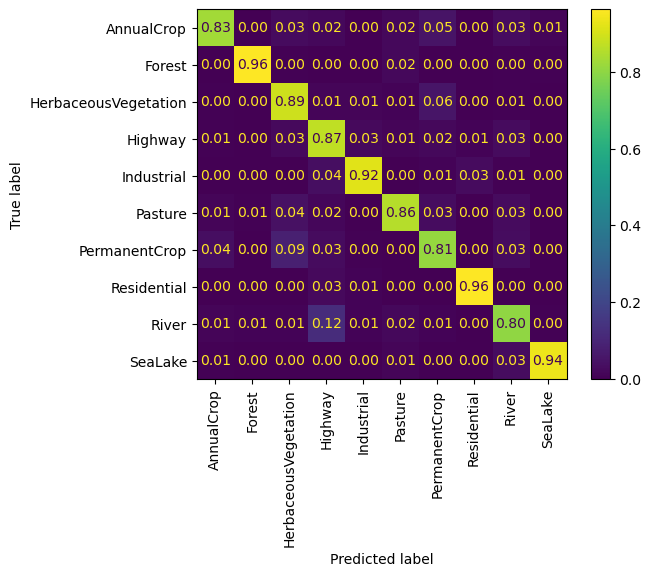

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(eval_labels, eval_predictions,
                                        normalize="true", values_format=".2f",
                                        display_labels=eval_set_ds.classes, xticks_rotation="vertical")

#### Showcase incorrect predictions

In [37]:
def show_sample_of_incorrect(idx_where_wrong, dataset, dataset_classes):
    np.random.seed(69)
    random_wrong_idxs = np.random.choice(idx_where_wrong, size=25, replace=False)
    fig = plt.figure(figsize=(10, 10), tight_layout=True)
    for i, idx in enumerate(random_wrong_idxs):
        ax = plt.subplot(5, 5, i + 1)
        plt.title(f"'{dataset_classes[int(eval_predictions[idx])]}'\n({dataset_classes[int(eval_labels[idx])]})")
        plt.imshow(einops.rearrange(dataset[idx]["image"], "c h w -> h w c"))
        plt.axis("off")

    return fig

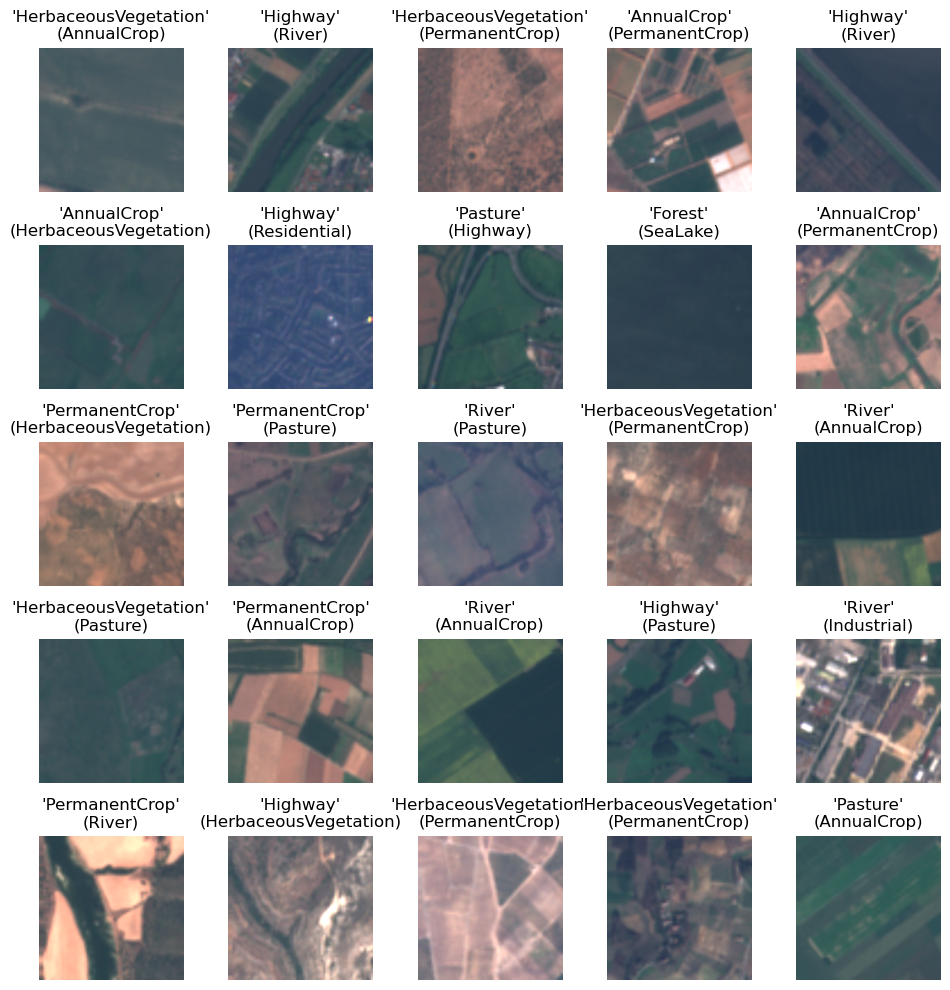

In [50]:
incorrect_idxs = np.where(eval_labels != eval_predictions)[0]

_ = show_sample_of_incorrect(incorrect_idxs, eval_set_ds, eval_set_ds.classes)

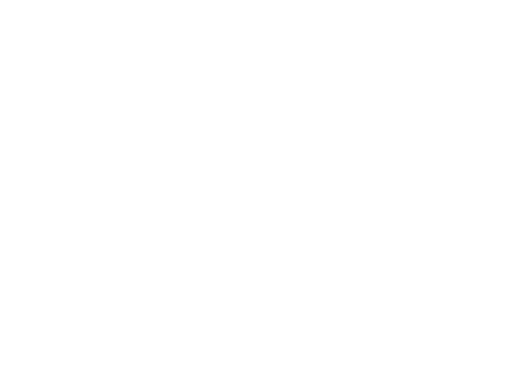

In [55]:
num_columns = 20
concat_images = torch.stack(
    [eval_set_ds[idx]["image"] for idx in incorrect_idxs[:len(incorrect_idxs) // num_columns * num_columns]])
plt.axis("off")
plt.imsave("output/basic_CNN_all_incorrect.png",
           einops.rearrange(concat_images, "(rows cols) c h w -> (rows h) (cols w) c", cols=num_columns).numpy())

In [39]:
eurosat_test_ds.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

Text(0.5, 0.98, 'Predicted as Highway but true label is River')

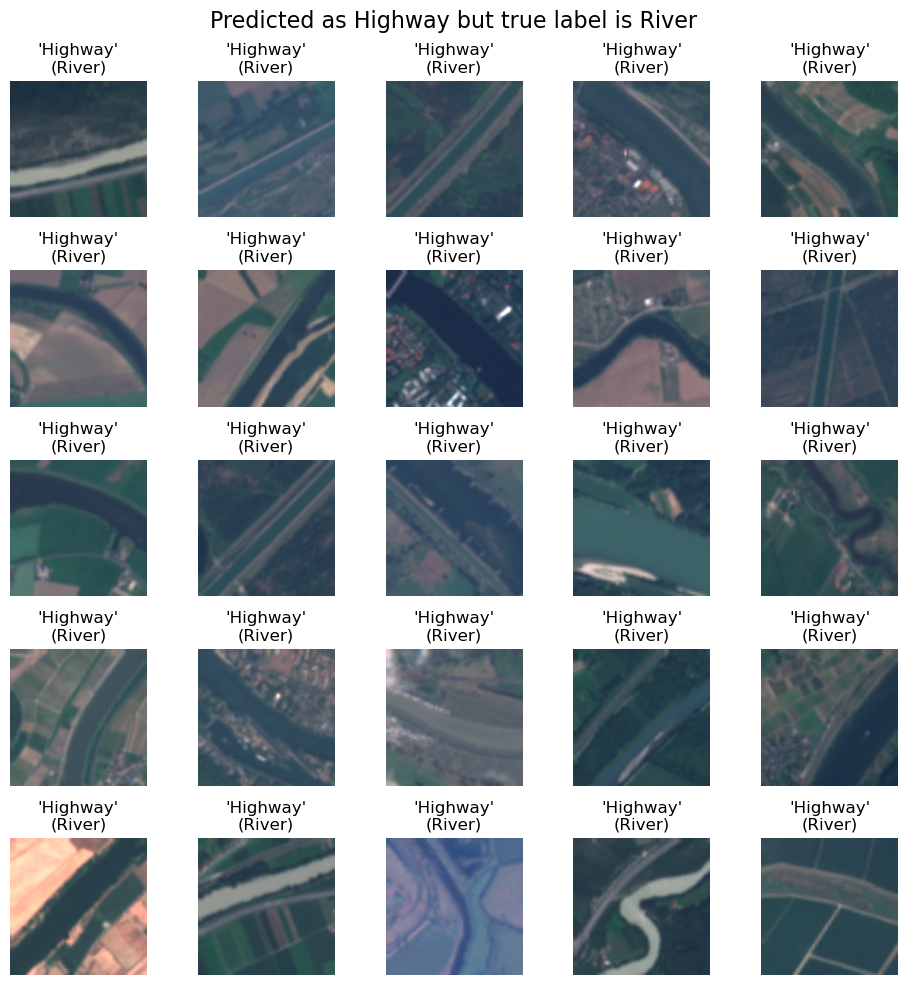

In [45]:
# get the indices where highway was predicted but true label was river
incorrect_idxs = np.where((eval_predictions == 3.0) & (eval_labels == 8.0))[0]

f = show_sample_of_incorrect(incorrect_idxs, eval_set_ds, eval_set_ds.classes)
f.suptitle(f"Predicted as {eval_set_ds.classes[3]} but true label is {eval_set_ds.classes[8]}", fontsize=16)

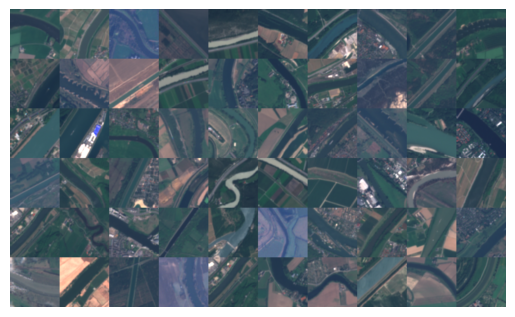

In [49]:
concat_images = torch.stack([eval_set_ds[idx]["image"] for idx in incorrect_idxs[:len(incorrect_idxs) // 10 * 10]])
plt.axis("off")
plt.imshow(einops.rearrange(concat_images, "(rows cols) c h w -> (rows h) (cols w) c", cols=10))

## Fine-tuning pretrained models

In [11]:
import torchvision

### ResNet50

In [12]:
class ResNet50FineTuned(nn.Module):
    def __init__(self, num_classes=len(eurosat_test_ds.classes)):
        super().__init__()
        # load with pre-trained weights
        self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

    def freeze_layers(self, from_input_up_to: int):
        """
        Freeze layers (requires_grad = False) up to a certain depth from the input layer.
        :param from_input_up_to: Depth exclusive to freeze layers up to
        :return: 
        """
        for depth_from_input, layer in enumerate(self.model.children()):
            if depth_from_input < from_input_up_to:
                for param in layer.parameters():
                    param.requires_grad = False

    def unfreeze_layers(self):
        """
        Unfreeze all layers in the model.
        :return: 
        """
        for param in self.parameters():
            param.requires_grad = True

    def extra_repr(self):
        """
        Add additional detail on number of frozen layers.
        :return: 
        """
        num_frozen = 0
        frozen_layers = []
        for layer in self.model.children():
            for param in layer.parameters():
                if not param.requires_grad:
                    num_frozen += 1
                    frozen_layers.append(layer)
                    break

        return f"> {num_frozen} layers frozen: {', '.join([layer.__class__.__name__ for layer in frozen_layers])} <"


resnet = ResNet50FineTuned().to(device)

### Data loading

In [13]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


# num_workers=0 is used to avoid a bug in the DataLoader when trying to pickle functions on windows
# see https://discuss.pytorch.org/t/cant-pickle-local-object-dataloader-init-locals-lambda/31857/31
train_dataloader = torch.utils.data.DataLoader(eurosat_train_ds, batch_size=16, num_workers=0, shuffle=True)
testing_dataloader = torch.utils.data.DataLoader(eurosat_test_ds, batch_size=32, num_workers=0, shuffle=True)
test_iterator = iter(cycle(testing_dataloader))

### Training

#### Final Layer Fine-tuning

In [47]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
decay = 1e-6
momentum = 0.9

In [48]:
# freeze all layers except the last one initially
resnet.freeze_layers(len(list(resnet.model.children())) - 1)
print(resnet)

Epoch 000
Epoch 000 - Batch num 00000
Training loss: 2.42, Training accuracy: 0.06
Testing loss: 2.35, Testing accuracy: 0.12
Epoch 000 - Batch num 00200
Training loss: 0.78, Training accuracy: 0.75
Testing loss: 0.32, Testing accuracy: 0.90
Epoch 000 - Batch num 00400
Training loss: 0.28, Training accuracy: 0.94
Testing loss: 0.36, Testing accuracy: 0.87
Epoch 000 - Batch num 00600
Training loss: 0.42, Training accuracy: 0.88
Testing loss: 0.39, Testing accuracy: 0.88
Epoch 000 - Batch num 00800
Training loss: 1.01, Training accuracy: 0.75
Testing loss: 0.35, Testing accuracy: 0.90
Epoch 000 - Batch num 01000
Training loss: 0.06, Training accuracy: 1.00
Testing loss: 0.22, Testing accuracy: 0.92
Epoch 001
Epoch 001 - Batch num 00000
Training loss: 0.51, Training accuracy: 0.81
Testing loss: 0.24, Testing accuracy: 0.92
Epoch 001 - Batch num 00200
Training loss: 0.80, Training accuracy: 0.81
Testing loss: 0.36, Testing accuracy: 0.89
Epoch 001 - Batch num 00400
Training loss: 0.25, Tra

KeyboardInterrupt: 

In [49]:
parameters_to_optimise = filter(lambda p: p.requires_grad, resnet.parameters())
optimiser = torch.optim.SGD(parameters_to_optimise, lr=learning_rate, weight_decay=decay, momentum=momentum,
                            nesterov=True)

In [ ]:
num_epochs = 120

wandb.init(
    project="basic_eurosat_classification_lit_replication",
    name="Fine-tuning ResNet50",
    notes="Fine-tuning ResNet50 on EuroSAT dataset.",
    config={
        "transforms": repr(base_transforms),
        "model_architecture": repr(resnet),
        "criterion": criterion.__class__.__name__,
        "optimiser_info": {
            "name": optimiser.__class__.__name__,
            "learning_rate": learning_rate,
            "decay": decay,
            "momentum": momentum
        },
        "dataset": "EuroSAT",
        "epochs": num_epochs,
        "start_time": time.asctime()
    }
)

training_loss_arr = np.zeros(0)
training_acc_arr = np.zeros(0)

for epoch in range(num_epochs):
    print(f"Epoch {epoch:03}")
    for i, data in enumerate(train_dataloader):
        resnet.train()
        images = data["image"].to(device)
        labels: torch.Tensor = data["label"].to(device)
        train_step(resnet, images, labels, criterion, optimiser, training_loss_arr, training_acc_arr, test_iterator, i)

    if epoch != 0 and epoch % 20 == 0:
        st.save_model(resnet, f"checkpoints/resnet50_eurosat_epoch_{epoch:03}.safetensors",
                      metadata={"epoch": str(epoch)})
        print(f"Model saved at epoch {epoch:03}.")

In [50]:
st.save_model(resnet, f"checkpoints/resnet50_eurosat_one_layer_finetune.safetensors", metadata={"epoch": str(2)})

ResNet50FineTuned(
  > 0 layers frozen:  <
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

#### Full Model Fine-tuning

In [61]:
resnet.unfreeze_layers()
resnet

New Epoch 003
Epoch 003 - Batch num 00000
Training loss: 0.83, Training accuracy: 0.81
Testing loss: 0.71, Testing accuracy: 0.85
Epoch 003 - Batch num 00200
Training loss: 0.25, Training accuracy: 0.94
Testing loss: 0.18, Testing accuracy: 0.95
Epoch 003 - Batch num 00400
Training loss: 0.63, Training accuracy: 0.81
Testing loss: 0.14, Testing accuracy: 0.96
Epoch 003 - Batch num 00600
Training loss: 0.61, Training accuracy: 0.81
Testing loss: 0.14, Testing accuracy: 0.95
Epoch 003 - Batch num 00800
Training loss: 0.28, Training accuracy: 0.94
Testing loss: 0.08, Testing accuracy: 0.97
Epoch 003 - Batch num 01000
Training loss: 0.20, Training accuracy: 0.88
Testing loss: 0.10, Testing accuracy: 0.97
New Epoch 004
Epoch 004 - Batch num 00000
Training loss: 0.06, Training accuracy: 1.00
Testing loss: 0.10, Testing accuracy: 0.96
Epoch 004 - Batch num 00200
Training loss: 0.44, Training accuracy: 0.88
Testing loss: 0.13, Testing accuracy: 0.96
Epoch 004 - Batch num 00400
Training loss: 0

KeyboardInterrupt: 

In [62]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005  # middle ground between 0.01 and 0.0001 range given by authors
decay = 1e-6
momentum = 0.9
optimiser = torch.optim.SGD(resnet.parameters(), lr=learning_rate, weight_decay=decay, momentum=momentum, nesterov=True)

In [63]:
training_loss_arr = np.zeros(0)
training_acc_arr = np.zeros(0)

for epoch in range(3, num_epochs):
    print(f"New Epoch {epoch:03}")
    for i, data in enumerate(train_dataloader):
        resnet.train()
        images = data["image"].to(device)
        labels: torch.Tensor = data["label"].to(device)
        train_step(resnet, images, labels, criterion, optimiser, training_loss_arr, training_acc_arr, test_iterator, i)

In [ ]:
st.save_model(resnet, "checkpoints/resnet50_eurosat_full_finetuned.safetensors", metadata={"epoch": str(7)})

In [67]:
wandb.finish()

Accuracy of the model on the 5400 test images: 0.98


In [14]:
st.load_model(resnet, "checkpoints/resnet50_eurosat_full_finetuned.safetensors", device="cuda")

(set(), [])

### Evaluation

In [ ]:
eval_labels, eval_predictions, eval_logits = evaluate_model(resnet, eval_dataloader)

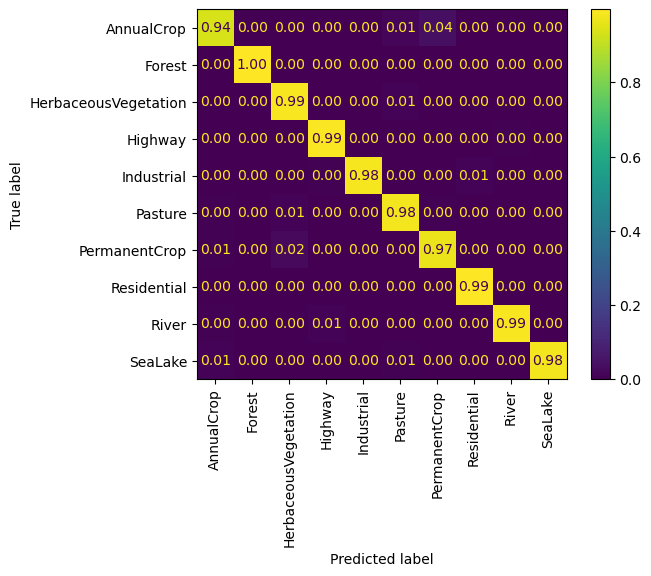

In [70]:
np.mean(eval_labels == eval_predictions)

#### Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(eval_labels, eval_predictions,
                                        normalize="true", values_format=".2f",
                                        display_labels=eval_set_ds.classes, xticks_rotation="vertical")

# Explainability

### Load models from checkpoints

In [32]:
cnn_model = BaseCNN()
st.load_model(cnn_model, "checkpoints/basic_cnn_eurosat_epoch_036.safetensors", device="cuda")
cnn_model.to(device)
cnn_model.eval()
next(cnn_model.parameters()).device

device(type='cuda', index=0)

## Basic Analysis

### Sample of incorrect predictions

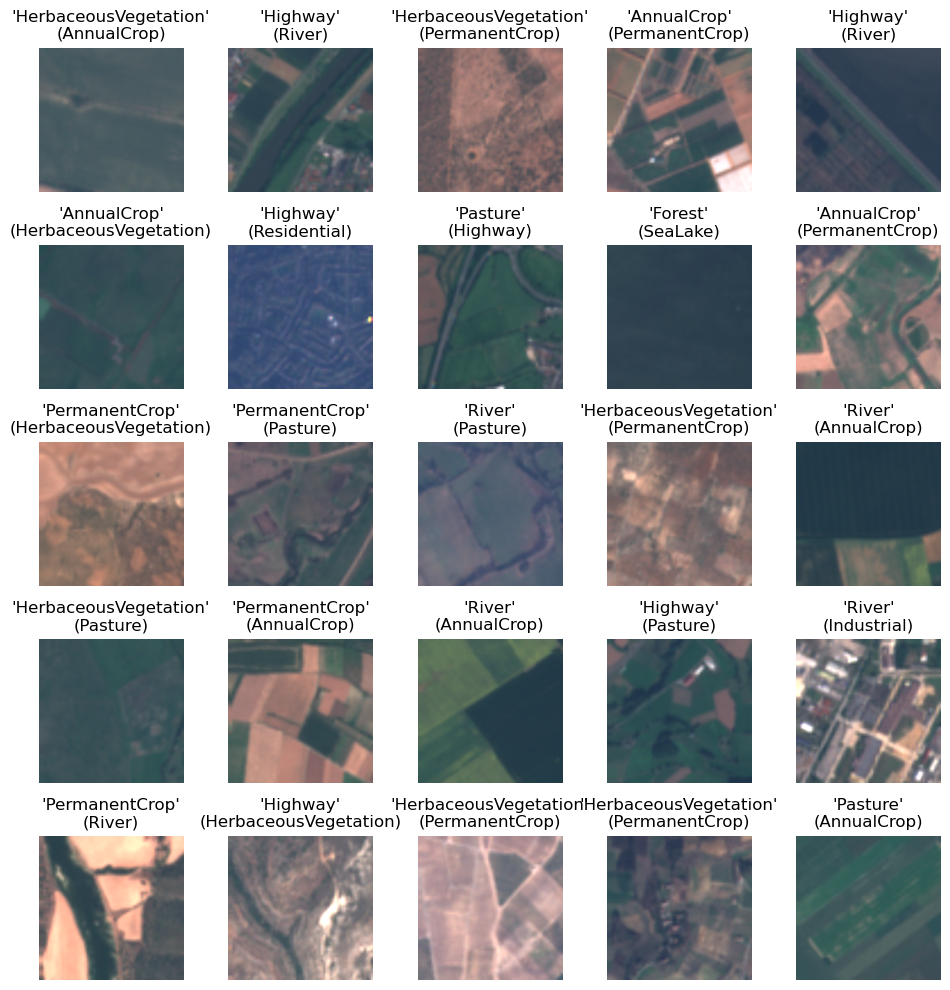

In [244]:
incorrect_idxs = np.where(eval_labels != eval_predictions)[0]

_ = show_sample_of_incorrect(incorrect_idxs, eval_set_ds, eval_set_ds.classes)

In [245]:
ic_sample_num_rows = 5
ic_sample_num_cols = 5
ic_sample_num_images = ic_sample_num_rows * ic_sample_num_cols
ic_sample_idxs = np.random.choice(incorrect_idxs, size=ic_sample_num_images, replace=False)
ic_sample = torch.stack([eval_set_ds[idx]["image"] for idx in ic_sample_idxs])

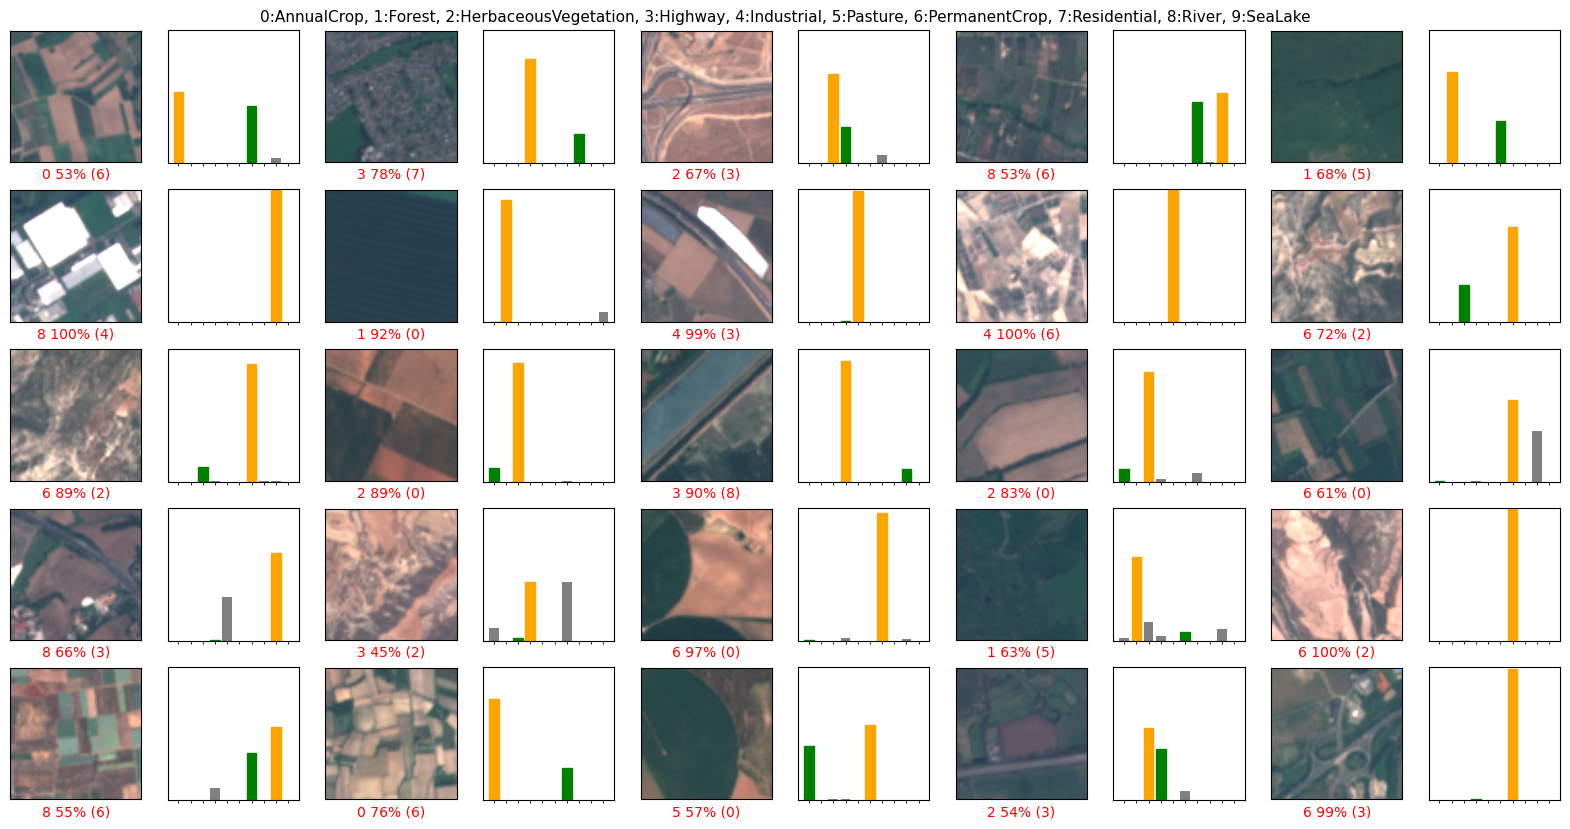

In [247]:
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(img, (1, 2, 0))  # move colour channel to end
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = "green" if predicted_label == true_label else "red"

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                         100 * np.max(predictions_array),
                                         true_label),
               color=color)


def plot_pred_bars(predictions_array, true_label):
    x_range = range(len(eval_set_ds.classes))
    plt.grid(False)
    plt.xticks([])
    plt.xticks(list(x_range), minor=True)
    plt.yticks([])
    thisplot = plt.bar(x_range, predictions_array, color="grey")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("orange")
    thisplot[true_label].set_color("green")


eval_sample_preds = nn.functional.softmax(torch.Tensor(eval_logits[ic_sample_idxs]), dim=1).numpy()
eval_sample_labels = eval_labels[ic_sample_idxs].astype(int)

plt.figure(figsize=(2 * 2 * ic_sample_num_cols, 2 * ic_sample_num_rows))
plt.title(", ".join([f"{i}:{cls}" for i, cls in enumerate(eval_set_ds.classes)]), fontsize=11)
plt.axis(False)
for i, image in enumerate(ic_sample):
    plt.subplot(ic_sample_num_rows, 2 * ic_sample_num_cols, 2 * i + 1)
    plot_image(eval_sample_preds[i], eval_sample_labels[i], image.numpy())
    plt.subplot(ic_sample_num_rows, 2 * ic_sample_num_cols, 2 * i + 2)
    plot_pred_bars(eval_sample_preds[i], eval_sample_labels[i])


### Analyse 'how wrong' the model was (i.e. how confident was it in the wrong class and how close was it to the correct class)

In [274]:
idxs_where_secondary_preds_correct = np.where(np.argsort(eval_logits, axis=1)[:, -2] == eval_labels.astype(int))[0]
probs_for_secondary_idxs = nn.functional.softmax(torch.Tensor(eval_logits[idxs_where_secondary_preds_correct]),
                                                 dim=1).numpy()
two_largest = np.partition(probs_for_secondary_idxs, -2, axis=1)[:, -2:]
confidence_diff = np.mean(np.abs(two_largest[:, 1] - two_largest[:, 0]))
print(
    f"Average confidence difference between correct and 2nd most confident class when 2nd was actually correct: {confidence_diff:.3f}")

Average confidence difference between correct and 2nd most confident class when 2nd was actually correct: 0.602


In [275]:
primary_acc = np.sum(eval_predictions == eval_labels.astype(int)) / len(eval_labels)
print(f"Primary accuracy: {primary_acc:.3f}")
# get the indices of the second most confident class (2nd highest logit)
secondary_acc = len(idxs_where_secondary_preds_correct) / len(eval_labels)
print(f"Second attempt accuracy: {secondary_acc:.3f}")
print(f"Completely failed: {1 - primary_acc - secondary_acc:.3f}")

Primary accuracy: 0.886
Second attempt accuracy: 0.083
Completely failed: 0.031


## LIME

In [ ]:
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

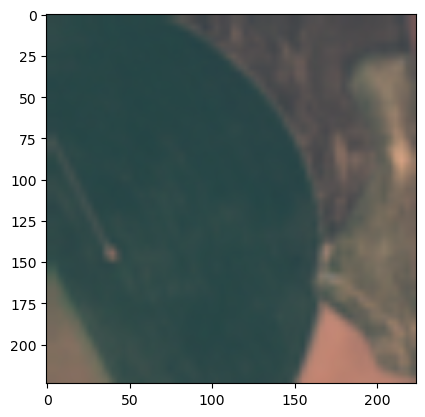

In [184]:
selected_idx = np.random.choice(incorrect_idxs)
image_to_explain = eval_set_ds[selected_idx]["image"]
image_to_explain_hwc = einops.rearrange(image_to_explain.numpy(), "c h w -> h w c")
plt.imshow(image_to_explain_hwc)

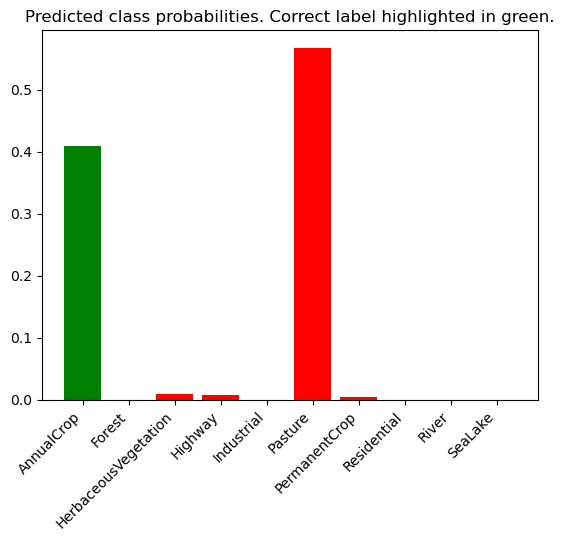

In [185]:
correct_label = int(eval_set_ds[selected_idx]["label"])
probs = nn.functional.softmax(model(image_to_explain.to(device).unsqueeze(0)), dim=1).cpu().detach()
# plot histogram of class probabilities (highlight correct)
_ = plt.bar(
    eval_set_ds.classes,
    probs.squeeze().numpy(),
    color=['green' if i == correct_label else 'red' for i in range(len(eval_set_ds.classes))]
)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.title("Predicted class probabilities. Correct label highlighted in green.")

In [186]:
ranked_labels = np.argsort(-probs.numpy().squeeze())
ranked_labels

array([5, 0, 2, 3, 6, 8, 1, 9, 4, 7], dtype=int64)

In [187]:
correct_index_rank = ranked_labels.tolist().index(correct_label)
print(
    f"Correct label was {correct_index_rank}-th (0-indexed) most confident class with probability {probs[0, correct_label].item():.3f}")

Correct label was 1-th (0-indexed) most confident class with probability 0.410


In [188]:
def batch_predict(perturbed_images_hwc):
    model.eval()
    batch = torch.stack([torch.Tensor(im) for im in perturbed_images_hwc], dim=0)
    batch = einops.rearrange(batch, "b h w c -> b c h w")

    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [189]:
explainer = LimeImageExplainer()
explanation = explainer.explain_instance(
    image_to_explain_hwc, batch_predict, hide_color=0, num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

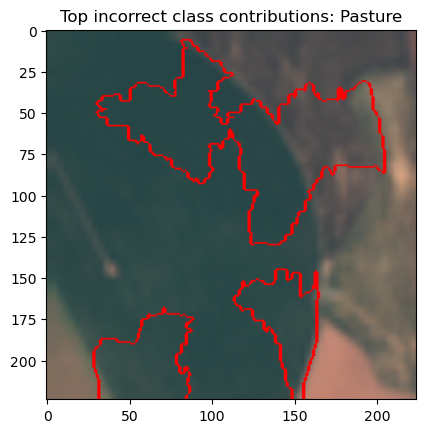

In [190]:
top_wrong_label = ranked_labels[0]
_, mask = explanation.get_image_and_mask(top_wrong_label, positive_only=True, num_features=5)
plt.title(f"Top incorrect class contributions: {eval_set_ds.classes[top_wrong_label]}")
plt.imshow(mark_boundaries(image_to_explain_hwc, mask, color=(1, 0, 0)))

### If wasn't just the second most confident class (bad!), visualise the top 3 classes

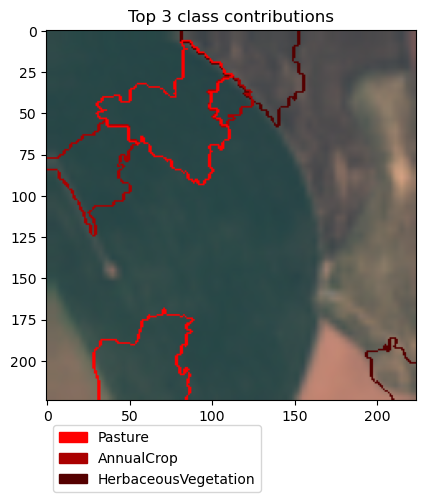

In [202]:
import matplotlib.patches as mpatches

masks = []
combined_masked_img = image_to_explain_hwc.copy()
legend_handlers = []
for i in range(2, -1, -1):  # reverse to make sure the most confident class is on top
    _, mask = explanation.get_image_and_mask(ranked_labels[i], positive_only=True, num_features=2)
    combined_masked_img = mark_boundaries(combined_masked_img, mask, color=(1 - i / 3, 0, 0))
    legend_handlers.append(mpatches.Patch(color=(1 - i / 3, 0, 0), label=eval_set_ds.classes[ranked_labels[i]]))

plt.title("Top 3 class contributions")
plt.imshow(combined_masked_img)
plt.legend(handles=legend_handlers[::-1], bbox_to_anchor=(0, -0.05), loc="upper left")

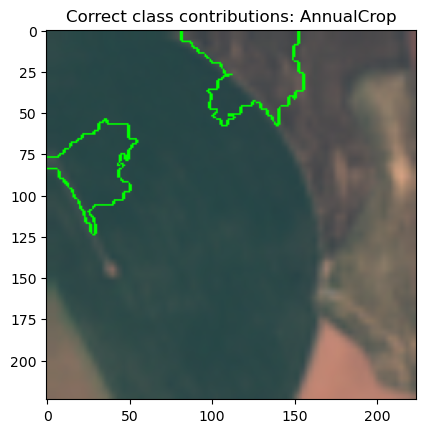

In [203]:
_, mask = explanation.get_image_and_mask(correct_label, positive_only=True, num_features=3)
plt.title(f"Positive correct class contributions: {eval_set_ds.classes[correct_label]}")
plt.imshow(mark_boundaries(image_to_explain_hwc, mask, color=(0, 1, 0)))

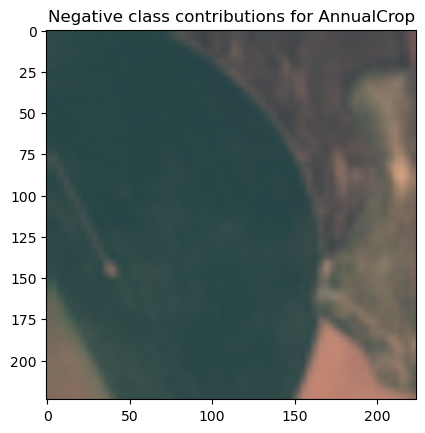

In [204]:
_, mask = explanation.get_image_and_mask(correct_label, positive_only=False, negative_only=True, num_features=3)
plt.title(f"Negative correct class contributions for {eval_set_ds.classes[correct_label]}")
plt.imshow(mark_boundaries(image_to_explain_hwc, mask, color=(1, 1, 0)))

## SHAP

In [90]:
import shap
from captum.attr import DeepLiftShap
from tqdm.notebook import tqdm

In [34]:
eval_set_ds = datasets.eurosat.get_dataset("val", transforms=wrapped_rescale_clamp_transform)
eval_dataloader_shuffled = iter(torch.utils.data.DataLoader(eval_set_ds, batch_size=128, num_workers=0, shuffle=True))

In [35]:
batch1 = next(eval_dataloader_shuffled)
batch1["image"].shape, batch1["label"].shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [78]:
background_images = batch1["image"][:5].to(device)
images_to_show = batch1["image"][100:].to(device)
# e = shap.DeepExplainer(cnn_model, background)
e = DeepLiftShap(cnn_model)

In [91]:
# shaps = e.shap_values(images_to_show[:1], check_additivity=False)
shap_values = torch.zeros(0).to(device)
for image_to_explain in tqdm(images_to_show[:10]):
    image_shap_values = torch.zeros(0).to(device)
    for i in tqdm(range(len(eval_set_ds.classes)), leave=False):
        shap_values_for_class_i = e.attribute(image_to_explain.unsqueeze(0), background_images,
                                              target=torch.tensor(i).to(device))
        image_shap_values = torch.cat(
            (image_shap_values, shap_values_for_class_i),
            dim=0
        ) if image_shap_values.size else shap_values_for_class_i

    shap_values = torch.cat((shap_values, image_shap_values.unsqueeze(0)), dim=0)

shap_values = shap_values.detach()
shap_values.size()

C:\Users\lucah\AppData\Local\Temp\ipykernel_33008\488068609.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_to_explain in tqdm(images_to_show[:10]):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\lucah\AppData\Local\Temp\ipykernel_33008\488068609.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(eval_set_ds.classes)), leave=False):


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([10, 10, 3, 224, 224])

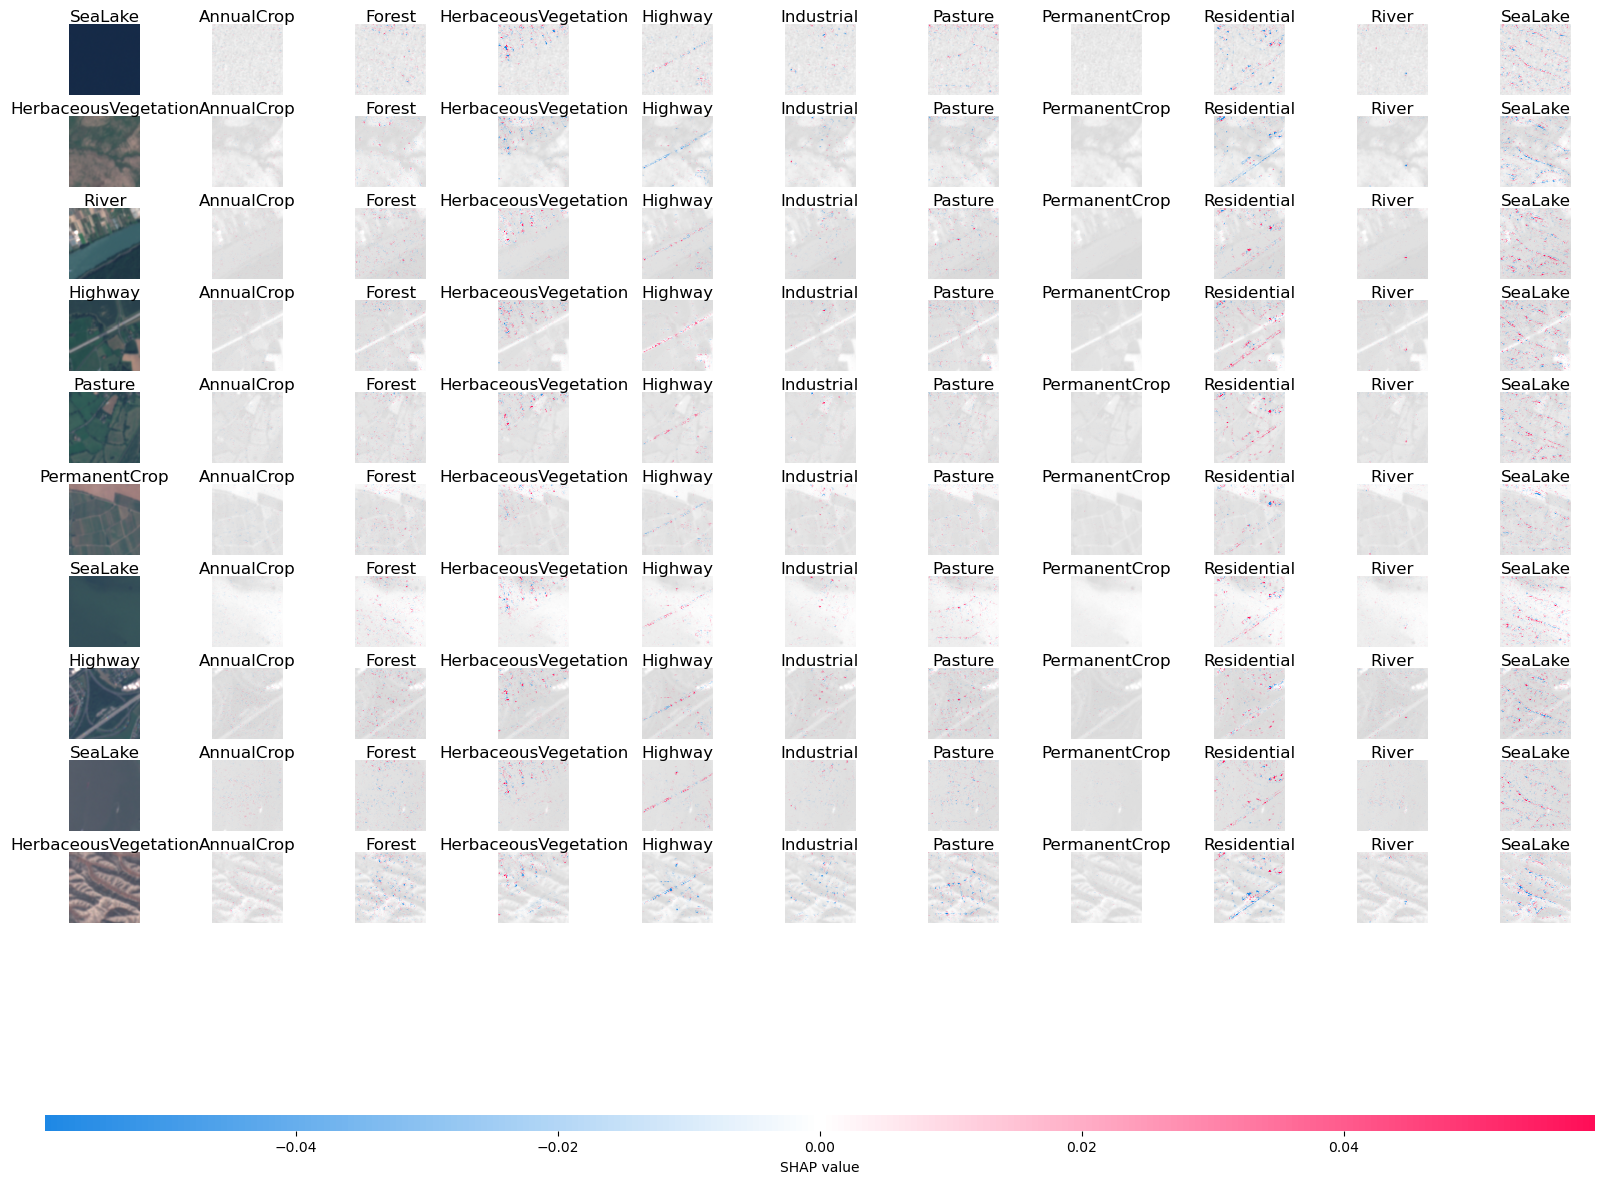

In [110]:
shap_to_display = list(einops.rearrange(shap_values, "b label ch h w -> b label h w ch").cpu().numpy())
test_images = einops.rearrange(images_to_show[:10].squeeze(), "b c h w -> b h w c").cpu().numpy()
shap.image_plot(shap_to_display, test_images, labelpad=0.3, hspace=0.3,
                labels=np.tile(eval_set_ds.classes, (images_to_show[:10].shape[0], 1)),
                true_labels=[eval_set_ds.classes[int(i)] for i in batch1["label"][100:][:10]],
                )  # todo: mark what was predicted by model; are these values right? they seem low.

In [ ]:
~